In [34]:
import numpy as np

In [6]:
import pandas as pd

stopwords = pd.read_csv('dataton2022-Latino_Asian_Brotherhood/src/data/archivos_auxiliares/stopwords.txt', names=['stopword'], header=None)
stopwords = stopwords['stopword']
stopwords = stopwords.str.replace('.', r'\.', regex=False)

clients = pd.read_csv('dataton2022-Latino_Asian_Brotherhood/src/data/archivos_auxiliares/clientes.csv', usecols=['nombre'])
clients['trimmed_name'] = clients['nombre']
for word in stopwords:
    clients['trimmed_name'] = clients['trimmed_name'].str.replace(r'(?:\s|^){}(?:\s|$)'.format(word), ' ', regex=True).str.strip()

clients.to_csv('dataton2022-Latino_Asian_Brotherhood/src/data/archivos_auxiliares/clean_names.csv', index=False)

In [24]:
import pandas as pd
import regex


def match_and_extract(row, *, text_col):
    pattern = r'\b(?<=(.{0,100}))('+'(.{0,20})'.join(row['trimmed_name'].split())+r')\b(?=(.{0,100}))'
#     pattern = r'\b(?<=(.{0,100}))('+row['trimmed_name']+r')\b(?=(.{0,100}))'
#     print(row['trimmed_name'])
    matches = regex.findall(pattern, row[text_col], flags=regex.I|regex.DOTALL)
#     print(matches)
    matches = [' '.join(x) for x in matches]
    return matches

regex_chars = ['.','(', ')']
client_df = pd.read_csv('dataton2022-Latino_Asian_Brotherhood/src/data/archivos_auxiliares/clientes.csv')
regroup_desc_ciiu_division = pd.read_csv('dataton2022-Latino_Asian_Brotherhood/src/data/archivos_auxiliares/regroup_desc_ciiu_division.csv')
client_df = pd.merge(client_df, regroup_desc_ciiu_division, how='left', on='desc_ciiu_division')
client_df['group'] = 'group_' + client_df['group'].astype(str)
clean_names = pd.read_csv('dataton2022-Latino_Asian_Brotherhood/src/data/archivos_auxiliares/clean_names.csv')
client_df = client_df.merge(clean_names, on='nombre')
for char in regex_chars:
    client_df['trimmed_name'] = client_df['trimmed_name'].str.replace(char, f'\{char}', regex=False)


client_news_df = pd.read_csv('dataton2022-Latino_Asian_Brotherhood/src/data/archivos_auxiliares/clientes_noticias.csv')[['nit', 'news_url_absolute','news_id']]
news_df = pd.read_csv('dataton2022-Latino_Asian_Brotherhood/src/data/archivos_auxiliares/noticias.csv')


client_news_df = client_news_df.merge(news_df, on='news_id')
client_news_df = client_news_df.merge(client_df, on='nit')

client_news_df['appearance_in_title'] = client_news_df.apply(match_and_extract, text_col='news_title', axis=1)
client_news_df['appearance_in_body'] = client_news_df.apply(match_and_extract, text_col='news_text_content', axis=1)

client_news_df['name_in_title'] = client_news_df['appearance_in_title'].map(len) > 0
client_news_df['name_in_body'] = client_news_df['appearance_in_body'].map(len) > 0
client_news_df['name_in_news'] = client_news_df['name_in_title'] | client_news_df['name_in_body']

client_news_df['appearance_in_title'] = client_news_df['appearance_in_title'].map(str)
client_news_df['appearance_in_body'] = client_news_df['appearance_in_body'].map(str)

# print(client_news_df[client_news_df[['name_in_body', 'name_in_body']].any(axis=1)])

client_news_df.head()

,nit,news_url_absolute_x,news_id,news_url_absolute_y,news_init_date,news_final_date,news_title,news_text_content,nombre,desc_ciiu_division,...,desc_ciiuu_clase,subsec,group,desc_ciiu_division_eng,trimmed_name,appearance_in_title,appearance_in_body,name_in_title,name_in_body,name_in_news
0,900378212,https://www.bluradio.com/economia/precio-dolar...,news10006,https://www.bluradio.com/economia/precio-dolar...,2022-07-30,2022-08-14,Precio dolar hoy: la cotizacion de la divisa a...,"Este martes, 2 de agosto, el dolar alcanzo un ...",BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",...,BANCOS COMERCIALES,BANCOS,group_30,"FINANCIAL SERVICES ACTIVITIES, EXCEPT INSURANC...",BANCO W,[],[],False,False,False
1,900378212,https://www.semana.com/economia/macroeconomia/...,news10011,https://www.semana.com/economia/macroeconomia/...,2022-07-30,2022-08-14,Es cierto: El presidente Gustavo Petro quiere ...,No hay nada mas permanente que lo temporal y a...,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",...,BANCOS COMERCIALES,BANCOS,group_30,"FINANCIAL SERVICES ACTIVITIES, EXCEPT INSURANC...",BANCO W,[],[],False,False,False
2,900378212,https://elcomercio.pe/respuestas/que/gustavo-p...,news10015,https://elcomercio.pe/respuestas/que/gustavo-p...,2022-07-30,2022-08-14,Gustavo Petro: ?Que dice el informe final de s...,El equipo de empalme del gobierno del presiden...,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",...,BANCOS COMERCIALES,BANCOS,group_30,"FINANCIAL SERVICES ACTIVITIES, EXCEPT INSURANC...",BANCO W,[],[],False,False,False
3,900378212,https://elcomercio.pe/mundo/actualidad/guerra-...,news10189,https://elcomercio.pe/mundo/actualidad/guerra-...,2022-07-30,2022-08-14,Banco Mundial anuncia nueva ayuda de 4.500 mil...,El Banco Mundial anuncio este lunes una ayuda ...,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",...,BANCOS COMERCIALES,BANCOS,group_30,"FINANCIAL SERVICES ACTIVITIES, EXCEPT INSURANC...",BANCO W,[],[],False,False,False
4,900378212,https://www.goal.com/es-mx/noticias/por-que-la...,news10192,https://www.goal.com/es-mx/noticias/por-que-la...,2022-07-30,2022-08-14,Por que LaLiga cambia de nombre y patrocinador...,**** LaLiga hizo oficial este martes el que s...,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",...,BANCOS COMERCIALES,BANCOS,group_30,"FINANCIAL SERVICES ACTIVITIES, EXCEPT INSURANC...",BANCO W,[],[],False,False,False


In [9]:
pred_group = pd.read_csv('../input/dataton-categorizacion-prediction/pred_news_group.csv')
pred_category = pd.read_csv('../input/dataton-categorizacion-prediction/pred_news_categorizacion.csv')

In [16]:
print(pred_category.columns.tolist())

['nit', 'news_id', 'news_url_absolute_x', 'news_init_date_x', 'news_final_date_x', 'news_url_absolute_y', 'news_init_date_y', 'news_final_date_y', 'news_title', 'news_text_content', 'text', 'Macroeconomía', 'Sostenibilidad', 'Innovación', 'Regulaciones', 'Alianza', 'Reputación', 'Descartable', 'preds', 'pred_category']


In [38]:
group_columns = ['group_30', 'group_40', 'group_28', 'group_29', 'group_20', 'group_25', 'group_1', 'group_32', 'group_16', 'group_23', 'group_11', 'group_22', 'group_19', 'group_39', 'group_49', 'group_2', 'group_44', 'group_18', 'group_13', 'group_26', 'group_41', 'group_36', 'group_31', 'group_14', 'group_12', 'group_27', 'group_43', 'group_21', 'group_7', 'group_46', 'group_35', 'group_48', 'group_33', 'group_38', 'group_5', 'group_4', 'group_47', 'group_6', 'group_42']
pred_group = pred_group[['nit', 'news_id', 'pred_group'] + group_columns]

category_columns = ['Macroeconomía', 'Sostenibilidad', 'Innovación', 'Regulaciones', 'Alianza', 'Reputación', 'Descartable']
pred_category = pred_category[['nit', 'news_id', 'preds', 'pred_category'] + category_columns]

In [26]:
client_news_df = client_news_df[['nit', 'news_id', 'nombre', 'desc_ciiu_division', 'group', 'trimmed_name', 'name_in_news']]

In [27]:
pred_df = client_news_df.merge(pred_group, on=['nit','news_id']).merge(pred_category, on=['nit','news_id'])
pred_df.head()

,nit,news_id,nombre,desc_ciiu_division,group,trimmed_name,name_in_news,group_30,group_40,group_28,...,pred_group,Macroeconomía,Sostenibilidad,Innovación,Regulaciones,Alianza,Reputación,Descartable,preds,pred_category
0,900378212,news10006,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.001493,0.010929,0.004812,...,group_21,0.970018,0.004870,0.004193,0.005514,0.004504,0.004560,0.006341,0,Macroeconomía
1,900378212,news10011,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.004341,0.010695,0.004320,...,group_25,0.004435,0.004970,0.004661,0.966562,0.004386,0.006255,0.008731,3,Regulaciones
2,900378212,news10015,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.001280,0.058838,0.002119,...,group_36,0.045784,0.012633,0.010301,0.854714,0.010383,0.042936,0.023249,3,Regulaciones
3,900378212,news10189,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.842878,0.000777,0.001196,...,group_30,0.123045,0.051315,0.047490,0.248521,0.046467,0.460593,0.022570,5,Reputación
4,900378212,news10192,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.003226,0.002456,0.404408,...,group_28,0.017231,0.013666,0.023596,0.017273,0.801303,0.090275,0.036656,4,Alianza


<AxesSubplot:ylabel='Count'>

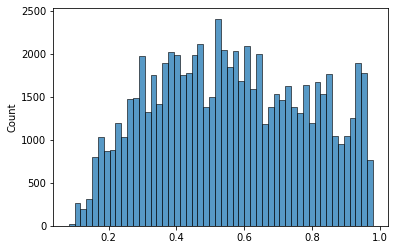

In [40]:
import seaborn as sns

sns.histplot(pred_df.apply(lambda row: np.max(row[group_columns].values), 1).values)

<AxesSubplot:ylabel='Count'>

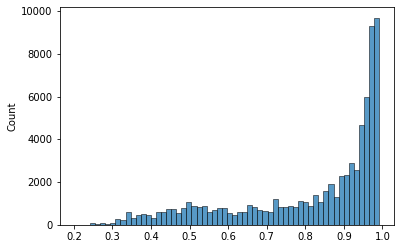

In [41]:
import seaborn as sns

sns.histplot(pred_df.apply(lambda row: np.max(row[category_columns].values), 1).values)

In [36]:
CLASSIFICATION_THRESHOLD = 0.7
def get_paricipacion(row):
    if row.group == row.pred_group and np.max(row[group_columns].values)>CLASSIFICATION_THRESHOLD:
        if row.name_in_news:
            return 'Cliente'
        else:
            return 'Sector'
    else:
        return 'No aplica'
    
pred_df['participacion'] = pred_df.apply(get_paricipacion,1)

In [44]:
def get_categoria(row):
    if np.max(row[category_columns].values)>CLASSIFICATION_THRESHOLD and row.pred_category != 'Descartable':
        return row.pred_category
    else:
        if row.participacion != 'No aplica':
            return 'Otra'
        else:
            return 'Descartable'
    
pred_df['categoria'] = pred_df.apply(get_categoria,1)

In [45]:
pred_df.head(10)

,nit,news_id,nombre,desc_ciiu_division,group,trimmed_name,name_in_news,group_30,group_40,group_28,...,Sostenibilidad,Innovación,Regulaciones,Alianza,Reputación,Descartable,preds,pred_category,participacion,categoria
0,900378212,news10006,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.001493,0.010929,0.004812,...,0.004870,0.004193,0.005514,0.004504,0.004560,0.006341,0,Macroeconomía,No aplica,Macroeconomía
1,900378212,news10011,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.004341,0.010695,0.004320,...,0.004970,0.004661,0.966562,0.004386,0.006255,0.008731,3,Regulaciones,No aplica,Regulaciones
2,900378212,news10015,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.001280,0.058838,0.002119,...,0.012633,0.010301,0.854714,0.010383,0.042936,0.023249,3,Regulaciones,No aplica,Regulaciones
3,900378212,news10189,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.842878,0.000777,0.001196,...,0.051315,0.047490,0.248521,0.046467,0.460593,0.022570,5,Reputación,Sector,Otra
4,900378212,news10192,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.003226,0.002456,0.404408,...,0.013666,0.023596,0.017273,0.801303,0.090275,0.036656,4,Alianza,No aplica,Alianza
5,900378212,news10194,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.543085,0.000471,0.000817,...,0.004895,0.005058,0.006131,0.034118,0.940193,0.005457,5,Reputación,No aplica,Reputación
6,900378212,news10198,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.003282,0.053645,0.002222,...,0.006153,0.005358,0.936253,0.006198,0.015351,0.012071,3,Regulaciones,No aplica,Regulaciones
7,900378212,news10201,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.006361,0.056130,0.008519,...,0.003869,0.004114,0.975749,0.003584,0.004101,0.005098,3,Regulaciones,No aplica,Regulaciones
8,900378212,news10240,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.818876,0.000426,0.000500,...,0.007687,0.006665,0.034760,0.007591,0.006278,0.007946,0,Macroeconomía,Sector,Macroeconomía
9,900378212,news10276,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.002570,0.014391,0.001724,...,0.002715,0.001920,0.002961,0.002324,0.002593,0.985117,6,Descartable,No aplica,Descartable


In [50]:
pred_df['nombre_equipo'] = 'Latino-Asian Brotherhood'

In [51]:
pred_df

,nit,news_id,nombre,desc_ciiu_division,group,trimmed_name,name_in_news,group_30,group_40,group_28,...,Innovación,Regulaciones,Alianza,Reputación,Descartable,preds,pred_category,participacion,categoria,nombre_equipo
0,900378212,news10006,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.001493,0.010929,0.004812,...,0.004193,0.005514,0.004504,0.004560,0.006341,0,Macroeconomía,No aplica,Macroeconomía,Latino-Asian Brotherhood
1,900378212,news10011,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.004341,0.010695,0.004320,...,0.004661,0.966562,0.004386,0.006255,0.008731,3,Regulaciones,No aplica,Regulaciones,Latino-Asian Brotherhood
2,900378212,news10015,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.001280,0.058838,0.002119,...,0.010301,0.854714,0.010383,0.042936,0.023249,3,Regulaciones,No aplica,Regulaciones,Latino-Asian Brotherhood
3,900378212,news10189,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.842878,0.000777,0.001196,...,0.047490,0.248521,0.046467,0.460593,0.022570,5,Reputación,Sector,Otra,Latino-Asian Brotherhood
4,900378212,news10192,BANCO W SA,"ACTIVIDADES DE SERVICIOS FINANCIEROS, EXCEPTO ...",group_30,BANCO W,False,0.003226,0.002456,0.404408,...,0.023596,0.017273,0.801303,0.090275,0.036656,4,Alianza,No aplica,Alianza,Latino-Asian Brotherhood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74683,800227924,news98007,COMERCIALIZADORA INTERNACIONAL INVERMEC SA,"FABRICACION DE PRODUCTOS ELABORADOS DE METAL, ...",group_13,COMERCIALIZADORA INVERMEC,False,0.000157,0.054820,0.002381,...,0.004476,0.008140,0.005971,0.006258,0.005035,0,Macroeconomía,No aplica,Macroeconomía,Latino-Asian Brotherhood
74684,890807976,news98000,BELLOTA COLOMBIA SAS CI,"FABRICACION DE PRODUCTOS ELABORADOS DE METAL, ...",group_13,BELLOTA COLOMBIA,False,0.001744,0.007798,0.001531,...,0.017930,0.169551,0.013787,0.719405,0.050656,5,Reputación,No aplica,Reputación,Latino-Asian Brotherhood
74685,890807976,news98004,BELLOTA COLOMBIA SAS CI,"FABRICACION DE PRODUCTOS ELABORADOS DE METAL, ...",group_13,BELLOTA COLOMBIA,False,0.000173,0.944443,0.002033,...,0.004181,0.004827,0.004546,0.005315,0.006768,0,Macroeconomía,No aplica,Macroeconomía,Latino-Asian Brotherhood
74686,890807976,news98005,BELLOTA COLOMBIA SAS CI,"FABRICACION DE PRODUCTOS ELABORADOS DE METAL, ...",group_13,BELLOTA COLOMBIA,False,0.002995,0.006257,0.006738,...,0.004058,0.004631,0.003724,0.014548,0.964710,6,Descartable,No aplica,Descartable,Latino-Asian Brotherhood


In [52]:
pred_df[['nombre_equipo', 'nit', 'news_id', 'participacion', 'categoria']].to_csv('categorizacion.csv')